In [1]:
from libhiaac.temporal.datasets.kuhar import BalancedTimeDomainKuHar
from libhiaac.temporal.datasets.dataset import TemporalSample
from libhiaac.temporal.transforms.transforms import Composer, MultiComposer, SpectrogramExtractor, SpectrogramColorMesh
from libhiaac.utils.dataset import SimpleDataset, SimpleDataLoader, DataLoader
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from typing import List
torch.cuda.is_available()

True

# Creating Dataset and Loaders

In [3]:
spectrogram_extract = SpectrogramExtractor(fs=100, nperseg=10, nooverlap=1)
spectrogram_mesher = SpectrogramColorMesh(figsize=(1, 1), shading="gouraud", vmin=0.0, vmax=0.0001)
piller = torchvision.transforms.ToPILImage()
resizer = torchvision.transforms.Resize((32,32))
tensorize = torchvision.transforms.ToTensor()
composer = Composer([spectrogram_extract, spectrogram_mesher, piller, resizer, tensorize])

In [4]:
train_dataset = BalancedTimeDomainKuHar(dataset_path="data/datasets/KuHar/Balanced", download=True, mode="train", transforms=composer)
val_dataset = BalancedTimeDomainKuHar(dataset_path="data/datasets/KuHar/Balanced", download=True, mode="validation", transforms=composer)
test_dataset = BalancedTimeDomainKuHar(dataset_path="data/datasets/KuHar/Balanced", download=True, mode="test", transforms=composer)

'data/datasets/KuHar/Balanced/train.csv' already exists and will not be downloaded again
Done!
'data/datasets/KuHar/Balanced/val.csv' already exists and will not be downloaded again
Done!
'data/datasets/KuHar/Balanced/test.csv' already exists and will not be downloaded again
Done!


In [5]:
processed_train_dataset = SimpleDataset(list(train_dataset))
processed_val_dataset = SimpleDataset(list(val_dataset))
processed_test_dataset = SimpleDataset(list(test_dataset))

In [6]:
def stack_tensors(keys: List[str], class_key: str):
    def _stack(batch):
        values = []
        for x in batch:
            values.append(torch.cat([x[key] for key in keys])) 
            
        xs = torch.stack(values, axis=0)
        ys = torch.tensor([x["meta"][class_key] for x in batch])
        return (xs, ys)
    return _stack

sensor_stacker = stack_tensors(keys=["accelerometer", "gyroscope"], class_key="class")

In [7]:
batch_size = 16
train_loader = SimpleDataLoader(processed_train_dataset, shuffle=True, batch_size=batch_size, batch_transform=sensor_stacker)
val_loader = SimpleDataLoader(processed_val_dataset, shuffle=True, batch_size=batch_size, batch_transform=sensor_stacker)
test_loader = SimpleDataLoader(processed_test_dataset, shuffle=True, batch_size=batch_size, batch_transform=sensor_stacker)
print(f"(batch size: {batch_size}) train batches: {len(train_loader)}, validation batches: {len(val_loader)}, test batches: {len(test_loader)}")

(batch size: 16) train batches: 150, validation batches: 12, test batches: 45


# Wrtting add transformation

In [8]:
import torch.fx
import uuid

def add_new_module(graph_module, graph_new_module, index: int):
    mod_name = str(uuid.uuid4())[:8]
    graph_module.add_submodule(mod_name, graph_new_module)
    
    cutoff_node: torch.fx.Node = list(graph_module.graph.nodes)[index]
    next_node: torch.fx.Node = list(graph_module.graph.nodes)[index+1]
    
    with graph_module.graph.inserting_after(cutoff_node):
        new_node = graph_module.graph.call_module(mod_name, (cutoff_node,), {})
    
    next_node.replace_input_with(cutoff_node, new_node)

    graph_module.graph.eliminate_dead_code()
    graph_module.recompile()
    graph_module.graph.lint()
    graph_module = torch.fx.symbolic_trace(graph_module)
    graph_module.delete_all_unused_submodules()
    return graph_module

class Conv1x1Module6to3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1x1 = torch.nn.Conv2d(in_channels=6, out_channels=3, kernel_size=(1,1))
        
    def forward(self, x):
        return self.conv1x1(x)
    
# from libhiaac.models.cnn import LeNet
# model = LeNet(num_classes=18)
# model_name = model.name
# model: torch.fx.GraphModule = torch.fx.symbolic_trace(model)

# conv1x1 = Conv1x1Module()
# conv1x1 = torch.fx.symbolic_trace(conv1x1)

# print(f"{'-'*30} BEFORE {'-'*30}") 
# model.graph.print_tabular()
# print(f"{'-'*80}\n") 

# model = add_new_module(model, conv1x1, 0)

# print(f"{'-'*30} AFTER {'-'*30}") 
# model.graph.print_tabular()
# print(f"{'-'*80}\n") 

# Train Loop

In [9]:
from collections import defaultdict

def train(model, loader: DataLoader, criterion, optimizer, device: str = "cpu"):
    train_acc = 0.0
    running_loss = 0.0
    #TODO per class acc in a func
    correct_pred = defaultdict(int)
    total_pred = defaultdict(int)
    
    for data, labels in loader:
        # get the inputs; data is a list of [inputs, labels]
        data = data.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update metrics
        running_loss += loss.item()
        
        _, predictions = torch.max(outputs, 1)
        train_acc += 100*(predictions == labels).float().mean()/len(loader)
        
        for label, prediction in zip(labels, predictions):
            label = int(label)
            if label == prediction:
                correct_pred[label] += 1
            total_pred[label] += 1
        
    return float(train_acc), dict(correct_pred), dict(total_pred), float(running_loss)


def test(model, loader: DataLoader, device: str = "cpu"):
    test_acc = 0.0
    correct_pred = defaultdict(int)
    total_pred = defaultdict(int)
    
    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            test_acc += 100*(predictions == labels).float().mean()/len(loader)
            for label, prediction in zip(labels, predictions):
                label = int(label)
                if label == prediction:
                    correct_pred[label] += 1
                total_pred[label] += 1

    return float(test_acc), dict(correct_pred), dict(total_pred)

def train_loop(model, train_loader: DataLoader, val_loader: DataLoader, test_loader: DataLoader = None, epochs: int = 10, device: str = "cpu", batch_size: int = 1, print_every: int = 1):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    model = model.to(device)
    metrics = defaultdict(list)
    for epoch in range(epochs):
        train_acc, train_correct_pred, train_total_pred, loss = train(model=model, loader=train_loader, criterion=criterion, optimizer=optimizer, device=device)
        val_acc, val_correct_pred, val_total_pred = test(model=model, loader=val_loader, device=device)
        loss = loss/batch_size
        if print_every != 0:
            if epoch % print_every == 0:
                print(f"[{epoch+1:4d}/{epochs:5d}] loss: {loss:8.4f}; train_acc: {train_acc:8.4f}; val_acc: {val_acc:8.4f}")
        
        metrics["train_acc"].append(train_acc)
        metrics["train_correct_pred"].append(train_correct_pred)
        metrics["train_total_pred"].append(train_total_pred)
        metrics["train_loss"].append(loss)
        metrics["val_acc"].append(val_acc)
        metrics["val_correct_pred"].append(val_correct_pred)
        metrics["val_total_pred"].append(val_total_pred)
        
    if test_loader is not None:
        test_acc, test_correct_pred, test_total_pred = test(model=model, loader=test_loader, device=device)
        metrics["test_acc"].append(test_acc)
        metrics["test_correct_pred"].append(test_correct_pred)
        metrics["test_total_pred"].append(test_total_pred)
        
    return dict(metrics)

In [10]:
import time
from contextlib import contextmanager

@contextmanager
def timer() -> float:
    start = time.time()
    yield lambda: time.time() - start
    
def print_train_summary(model_name, metrics_dict):
    train_acc = max(metrics_dict[model_name]["train_acc"])
    val_acc = max(metrics_dict[model_name]["val_acc"])
    if "test_acc" in metrics_dict[model_name]:
        test_acc = max(metrics_dict[model_name]["test_acc"])
    else:
        test_acc = 0.0
    loss = min(metrics_dict[model_name]["train_loss"])
    print(f"{model_name:20s} - loss: {loss:8.4f}; train_acc: {train_acc:8.4f}; val_acc: {val_acc:8.4f}; test_acc: {test_acc:8.4f}")
    
    print("Per class prediction")
    for key in sorted(metrics_dict[model_name]["test_total_pred"][-1].keys()):
        if key not in metrics_dict[model_name]['test_correct_pred'][-1]:
            metrics_dict[model_name]['test_correct_pred'][-1][key] = 0
        print(f"    Class {key:4d}: {100*metrics_dict[model_name]['test_correct_pred'][-1][key]/metrics_dict[model_name]['test_total_pred'][-1][key]:8.4f} %")
        
def plot_acc(model_name, train_acc, val_acc, loss, n_epochs):
    xs = np.arange(0, n_epochs, 1)
    plt.figure(figsize=(12, 8))
    plt.plot(xs, train_acc, label="train_acc")
    plt.plot(xs, val_acc, label="val_acc")
    plt.plot(xs, loss, label="loss")
    plt.xlabel('Epochs')
    plt.title(model_name)
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show()

# Process

In [13]:
from libhiaac.models.cnn import LeNet
model = LeNet(num_classes=18)
model_name = model.name
model: torch.fx.GraphModule = torch.fx.symbolic_trace(model)
metrics = dict()

conv1x1 = Conv1x1Module6to3()
conv1x1 = torch.fx.symbolic_trace(conv1x1)

model = add_new_module(model, conv1x1, 0)

with timer() as t:
    metrics[model_name] = train_loop(model=model, train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, epochs=100, device="cuda", batch_size=batch_size, print_every=5)
print(f"Execution took {t():.4f} seconds")
print_train_summary(model_name, metrics)

[   1/  100] loss:  27.1090; train_acc:   5.0000; val_acc:   4.1667
[   6/  100] loss:  23.4309; train_acc:  14.2500; val_acc:  17.7083
[  11/  100] loss:  17.2339; train_acc:  27.7083; val_acc:  29.1667
[  16/  100] loss:  16.6215; train_acc:  29.2917; val_acc:  22.9167
[  21/  100] loss:  16.4010; train_acc:  31.4167; val_acc:  29.1667
[  26/  100] loss:  16.0799; train_acc:  31.2917; val_acc:  32.8125
[  31/  100] loss:  15.9402; train_acc:  33.0833; val_acc:  30.7292
[  36/  100] loss:  15.7094; train_acc:  34.2083; val_acc:  32.2917
[  41/  100] loss:  15.3163; train_acc:  36.6667; val_acc:  35.9375
[  46/  100] loss:  14.7514; train_acc:  38.8750; val_acc:  40.6250
[  51/  100] loss:  14.0261; train_acc:  41.0417; val_acc:  35.9375
[  56/  100] loss:  13.5898; train_acc:  43.5000; val_acc:  39.0625
[  61/  100] loss:  13.5990; train_acc:  43.7083; val_acc:  35.9375
[  66/  100] loss:  13.0738; train_acc:  45.7917; val_acc:  35.4167
[  71/  100] loss:  12.7171; train_acc:  47.0417

In [15]:
import functools
import torch

from libhiaac.models.cnn.densenet import DenseNet121, DenseNet161, DenseNet169, DenseNet201, densenet_cifar
from libhiaac.models.cnn.dpn import DPN26, DPN92
from libhiaac.models.cnn.efficientnet import EfficientNetB0
from libhiaac.models.cnn.googlenet import GoogLeNet
from libhiaac.models.cnn.lenet import LeNet
from libhiaac.models.cnn.mobilenet import MobileNet
from libhiaac.models.cnn.mobilenetv2 import MobileNetV2
from libhiaac.models.cnn.pnasnet import PNASNetA, PNASNetB
from libhiaac.models.cnn.preact_resnet import PreActResNet18, PreActResNet34, PreActResNet50, PreActResNet101, PreActResNet152
from libhiaac.models.cnn.resnet import ResNet18, ResNet34, ResNet50, ResNet101, ResNet152
from libhiaac.models.cnn.resnext import ResNeXt29_2x64d, ResNeXt29_4x64d, ResNeXt29_8x64d, ResNeXt29_32x4d
from libhiaac.models.cnn.senet import SENet18
from libhiaac.models.cnn.shufflenet import ShuffleNetG2, ShuffleNetG3
from libhiaac.models.cnn.shufflenetv2 import ShuffleNetV2_05, ShuffleNetV2_10, ShuffleNetV2_15, ShuffleNetV2_20
from libhiaac.models.cnn.vgg import VGG_11, VGG_13, VGG_16, VGG_19 

metrics = dict()
epochs = 100
device = "cuda"
batch_size = batch_size
print_every = 10
num_classes = 18

def partialclass(cls, *args, **kwds):

    class NewCls(cls):
        __init__ = functools.partialmethod(cls.__init__, *args, **kwds)

    return NewCls

cnn_models = {
    'densenet121': functools.partial(DenseNet121, num_classes=num_classes),
    'densenet161': functools.partial(DenseNet161, num_classes=num_classes),
    'densenet169': functools.partial(DenseNet169, num_classes=num_classes),
    'densenet201': functools.partial(DenseNet201, num_classes=num_classes),
    'densenet_cifar': functools.partial(densenet_cifar, num_classes=num_classes),
    'dpn26': functools.partial(DPN26, num_classes=num_classes),
    'dpn92': functools.partial(DPN92, num_classes=num_classes),
    #'efficientnetb0': functools.partial(EfficientNetB0, num_classes=num_classes),
    'googlenet': partialclass(GoogLeNet, num_classes=num_classes),
    'lenet': partialclass(LeNet, num_classes=num_classes),
    'mobilenet': partialclass(MobileNet, num_classes=num_classes),
    'mobilenetv2': partialclass(MobileNetV2, num_classes=num_classes),
    'pnasnet_a': functools.partial(PNASNetA, num_classes=num_classes),
    'pnasnet_b': functools.partial(PNASNetB, num_classes=num_classes),
    'preactresnet18': functools.partial(PreActResNet18, num_classes=num_classes),
    'preactresnet34': functools.partial(PreActResNet34, num_classes=num_classes),
    'preactresnet50': functools.partial(PreActResNet50, num_classes=num_classes),
    'preactresnet101': functools.partial(PreActResNet101, num_classes=num_classes),
    'preactresnet152': functools.partial(PreActResNet152, num_classes=num_classes),
    'resnet18': functools.partial(ResNet18, num_classes=num_classes),
    'resnet34': functools.partial(ResNet34, num_classes=num_classes),
    'resnet50': functools.partial(ResNet50, num_classes=num_classes),
    'resnet101': functools.partial(ResNet101, num_classes=num_classes),
    'resnet152': functools.partial(ResNet152, num_classes=num_classes),
    'resnext29_2x64d': functools.partial(ResNeXt29_2x64d, num_classes=num_classes),
    'resnext29_4x64d': functools.partial(ResNeXt29_4x64d, num_classes=num_classes),
    'resnext29_8x64d': functools.partial(ResNeXt29_8x64d, num_classes=num_classes),
    'resnext29_32x4d': functools.partial(ResNeXt29_32x4d, num_classes=num_classes),
    #'senet18': functools.partial(SENet18, num_classes=num_classes),
    # 'shufflenetg2': ShuffleNetG2,
    # 'shufflenetg3': ShuffleNetG3,
    #'shufflenetv2_0.5': functools.partial(ShuffleNetV2_05, num_classes=num_classes),
    #'shufflenetv2_1.0': functools.partial(ShuffleNetV2_10, num_classes=num_classes),
    #'shufflenetv2_1.5': functools.partial(ShuffleNetV2_15, num_classes=num_classes),
    #'shufflenetv2_2.0': functools.partial(ShuffleNetV2_20, num_classes=num_classes),
    'vgg11': functools.partial(VGG_11, num_classes=num_classes),
    'vgg13': functools.partial(VGG_13, num_classes=num_classes),
    'vgg16': functools.partial(VGG_16, num_classes=num_classes),
    'vgg19': functools.partial(VGG_19, num_classes=num_classes)
}


In [16]:
def train_mixed_model(model, train_loader: DataLoader, val_loader: DataLoader, test_loader: DataLoader, epochs: int, device: str, batch_size: int, print_every: int):
    model_name = model.name
    model: torch.fx.GraphModule = torch.fx.symbolic_trace(model)

    conv1x1 = Conv1x1Module6to3()
    conv1x1 = torch.fx.symbolic_trace(conv1x1)

    model = add_new_module(model, conv1x1, 0)

    print(f"{'-'*30} Start training with model: {model_name} {'-'*30}")
    with timer() as t:
        metrics[model_name] = train_loop(model=model, train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, epochs=epochs, device=device, batch_size=batch_size, print_every=print_every)
    print(f"Execution took {t():.4f} seconds")
    print_train_summary(model_name, metrics)
    plot_acc(model_name=model_name, train_acc=metrics[model_name]["train_acc"], val_acc=metrics[model_name]["val_acc"], loss=metrics[model_name]["train_loss"], n_epochs=epochs)
    print(f"{'-'*30} Finish training with model: {model_name} {'-'*30}\n\n\n")

------------------------------ Start training with model: DenseNet121 ------------------------------
[   1/  100] loss:  19.7176; train_acc:  27.0417; val_acc:  29.6875
[  11/  100] loss:   9.8978; train_acc:  61.0833; val_acc:  47.3958
[  21/  100] loss:   4.9826; train_acc:  81.9583; val_acc:  48.4375
[  31/  100] loss:   2.0281; train_acc:  93.7500; val_acc:  44.2708
[  41/  100] loss:   0.5449; train_acc:  98.5416; val_acc:  46.3542
[  51/  100] loss:   0.3163; train_acc:  99.2499; val_acc:  43.7500
[  61/  100] loss:   0.1936; train_acc:  99.4583; val_acc:  45.3125
[  71/  100] loss:   0.0565; train_acc:  99.9582; val_acc:  45.8333
[  81/  100] loss:   0.0255; train_acc:  99.9999; val_acc:  45.3125
[  91/  100] loss:   0.0269; train_acc:  99.9999; val_acc:  45.8333
Execution took 911.5125 seconds
DenseNet121          - loss:   0.0105; train_acc:  99.9999; val_acc:  52.0833; test_acc:  45.0000
Per class prediction
    Class    0:  68.4211 %
    Class    1:  51.2821 %
    Class    2

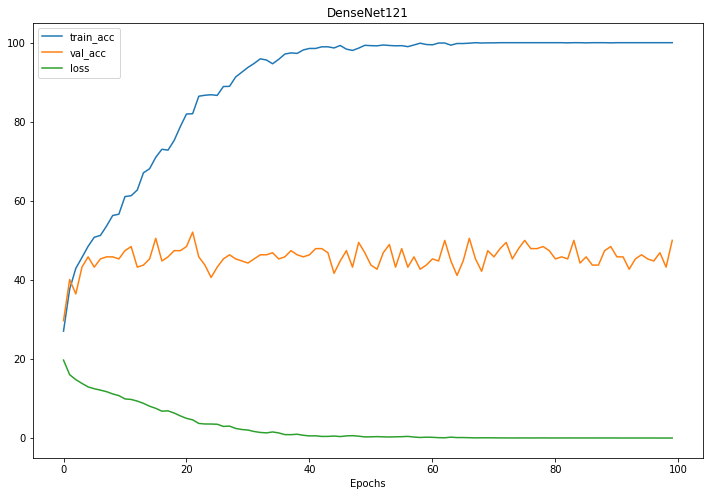

------------------------------ Finish training with model: DenseNet121 ------------------------------



------------------------------ Start training with model: DenseNet161 ------------------------------
[   1/  100] loss:  19.5289; train_acc:  25.6667; val_acc:  29.1667
[  11/  100] loss:   9.6417; train_acc:  61.9583; val_acc:  47.3958
[  21/  100] loss:   3.8406; train_acc:  85.1667; val_acc:  44.7917
[  31/  100] loss:   0.7015; train_acc:  97.7916; val_acc:  46.8750
[  41/  100] loss:   0.1398; train_acc:  99.7916; val_acc:  45.8333
[  51/  100] loss:   1.0799; train_acc:  96.3333; val_acc:  50.0000
[  61/  100] loss:   0.0839; train_acc:  99.9166; val_acc:  45.3125
[  71/  100] loss:   0.0426; train_acc:  99.9166; val_acc:  41.1458
[  81/  100] loss:   0.0146; train_acc:  99.9999; val_acc:  44.2708
[  91/  100] loss:   0.0076; train_acc:  99.9999; val_acc:  44.7917
Execution took 1539.3046 seconds
DenseNet161          - loss:   0.0059; train_acc:  99.9999; val_acc:  50.5208; te

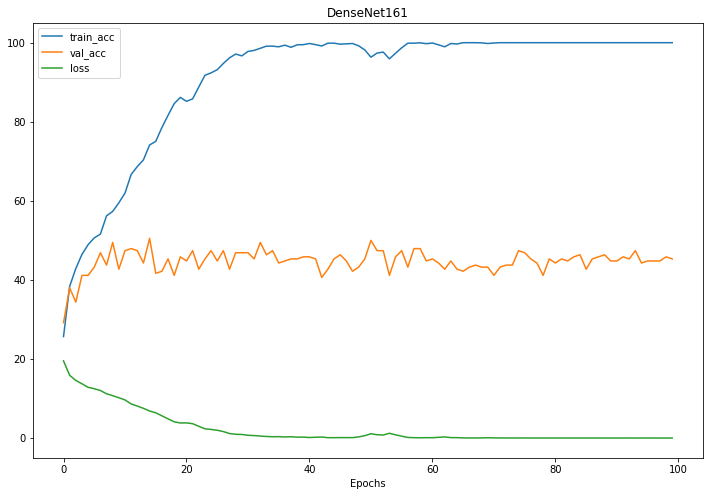

------------------------------ Finish training with model: DenseNet161 ------------------------------



------------------------------ Start training with model: DenseNet169 ------------------------------
[   1/  100] loss:  19.8192; train_acc:  25.7083; val_acc:  27.0833
[  11/  100] loss:   9.4737; train_acc:  62.4583; val_acc:  45.3125


KeyboardInterrupt: 

In [17]:
for model_name in sorted(cnn_models.keys()):
    model_cls = cnn_models[model_name]
    model = model_cls()
    train_mixed_model(model, train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, epochs=epochs, device=device, batch_size=batch_size, print_every=print_every)

In [ ]:
metrics